# Analysis and Text Classification of Fake News from Three Datasets
## Final Project-Unstructured Data Analysis 
### Zoe Papagianni-CID:01827902

## Introduction
In this notebook, we will perform an analysis and text classification of fake news using three separate datasets: 
* [Random_Political](https://github.com/BenjaminDHorne/fakenewsdata1)
* [MisInfoText](https://github.com/sfu-discourse-lab/MisInfoText#readme)
* [NELA-GT-2020](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CHMUYZ)

The git repository for this project can be found [here]()

The primary objective of this study is to design and evaluate a model for detecting and classifying fake news from online news sources. To achieve this goal, we will train a model on three separate datasets and evaluate its performance on each dataset individually. In addition to the classification task, we will also perform several other analyses, including identifying the most common words in the text, performing sentiment analysis, summarizing the text, and clustering the data. The results of these analyses will be used to improve the performance of the fake news detection model and to gain insights into the characteristics of fake news.

In [387]:
# Import libraries
import os
import re
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from spacy.tokens import DocBin
from tqdm import tqdm
from wordcloud import WordCloud
import time

import random

# Set the seed to 19
random.seed(19)

warnings.simplefilter(action='ignore', category=FutureWarning)

## Define text preprocessing functions

Before starting our analysis we define the functions that will be used to process the text. The function: 
* `lower_space` is used to convert newline characters to space character.
* `remove_url` is used to remove url from text.
* `remove_symbols` is used to remove special characters.
* `tokenize_row` that takes a single row of text as an input and returns a list of tokens.
* `remove_stopwords`  takes a list of tokens as an input and returns a filtered list of tokens that doesn't contain stopwords. 
* `stem_tokens` takes a list of tokens as an input and returns a list of stemmed tokens.In this case,we use the Porter stemmer.
* `lemmatize_words`reduces words to their base form while taking into account the part of speech and the context in which the word is used.
* `common_words`takes a dataframe as an input and returns a dataframe of the most common words.

In [15]:
# Preprocess text
# Convert text to lowercase and 
# replace newline character with space 
def lower_space(txt):
    f = txt.replace("\n", " ")
    return f.lower()

#Remove urls from text.
def remove_url(txt):
    # Use regrex to parse urls from the text
    parsed_text = re.sub(r"\S*https?:\S*", "", txt, flags=re.MULTILINE)
    return parsed_text

#Remove symbols from text.
def remove_symbols(txt):
    # Use regrex to remove symbols from the text
    parsed_text = re.sub(r'[^\w\s]', "", txt, flags=re.MULTILINE)
    return parsed_text

#Tokenise rows
def tokenize_row(row):
    tokens = nltk.word_tokenize(row)
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    #Import stop words from ntlk
    stop_words = nltk.corpus.stopwords.words('english')
    #Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

# Perform Stemming on each row
def stem_tokens(tokens):
    stemmer = nltk.stem.PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

## Find most common words in dataframe
def common_words(df):
    # Flatten the list of tokens into a single list
    all_tokens = [token for row in df for token in row]
    # Use the Counter class to count the frequency of each word
    word_counts = Counter(all_tokens)
    # Use the most_common() method to get the most common words
    most_common_words = word_counts.most_common(20)
    # Create dataframe
    common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
    return common_df

## Data Preparation

### Load and Preprocess Random Political Data

The Random_Political folder contains separate folders for the titles and text of true and false news articles. For this study, we will use the Fake_titles and Real_titles folders, which contain the titles of fake and real news articles, respectively. Each title is saved in a separate .txt file, and we will iterate through the folders to read the text files into a dataframe. Some dataframes may have more than one column, so we will combine the text into a single column for analysis

In [58]:
#Define folder path
folder_path = '../Datasets/Random_Political'
#Define directory path
fake_file = os.listdir(folder_path+'/Fake_titles')
#Initialise dataframe
fake_title = pd.DataFrame()
#Iterate through folder
print("Loading data...")
for file in fake_file:
    #Read text File
    fake_text = pd.read_csv(folder_path + '/Fake_titles/' + file,encoding="Windows-1252", header=None)
    #Add text to dataframe
    fake_title=fake_title.append(fake_text)
#Preview dataframe
fake_title.head()

Loading data...


,0,1,2,3,4
0,New Study Shows Illegal Immigrants to Outnumbe...,NaN,NaN,NaN,NaN
0,BREAKING: We just found out who attacked TRUMP,NaN,NaN,NaN,NaN
0,Obama To Issue Executive Order Extending Presi...,NaN,NaN,NaN,NaN
0,Donald Trump Tweets Image Of His Penis – WARNI...,NaN,NaN,NaN,NaN
0,BREAKING – Dems Caught Counting Hillary Votes ...,TIME FOR PRISON!,NaN,NaN,NaN


Upon examining the above dataframe, it is apparent that some sentences are saved in separate columns. In order to merge all text into a single column, we utilize the following command:

In [59]:
#Merge columns
fake_title['text'] = fake_title[fake_title.columns[0:]].apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis=1)
# Drop all columns apart from text.
fake_title = fake_title.loc[:, fake_title.columns == "text"]
fake_title.head()

,text
0,New Study Shows Illegal Immigrants to Outnumbe...
0,BREAKING: We just found out who attacked TRUMP
0,Obama To Issue Executive Order Extending Presi...
0,Donald Trump Tweets Image Of His Penis – WARNI...
0,BREAKING – Dems Caught Counting Hillary Votes ...


We repeat the same process for the Real_titles folder.

In [60]:
#Repeat process the Real_titles
real_file = os.listdir(folder_path+'/Real_titles')
real_title = pd.DataFrame()
for file in real_file:
    real_text = pd.read_csv(folder_path + '/Real_titles/' + file,encoding="Windows-1252", header=None)
    real_title=real_title.append(real_text)
real_title['text'] = real_title[real_title.columns[0:]].apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis=1
)
real_title = real_title.loc[:, real_title.columns == "text"]
real_title.head()

,text
0,Contradicting settled science Donald Trump say...
0,New Zealand's Parliament chooses new prime min...
0,No Government Shutdown: Senate Passes Funding ...
0,In Reversal Gambian President Rejects Loss And...
0,Trump says ‘nobody really knows’ if climate ch...


After the data was collected, we preprocessed the text in order to extract more meaningful information. As the news titles are single lines of text and do not contain URLs, we did not need to apply those specific functions to the text. Instead, we performed tokenization, removed symbols, eliminated stopwords, and applied stemming. Tokenization involves dividing the text into smaller units called tokens, which can be words, phrases, or symbols. Stopwords are common words that are typically removed from text before processing it, as they do not convey much meaning and can sometimes hinder the effectiveness of natural language processing tasks. Stemming is a process of reducing words to their base form, or stem, using a tool such as the Snowball stemmer. This can be useful for text classification, as variations of a word may not add significant meaning.

In [63]:
def process_titles(df):
    #Convert to lower case
    df['text'] = df['text'].apply(lower_space)
    #Remove symbols
    df['text'] = df['text'].apply(remove_symbols)
    #Convert to tokens
    df['tokens'] = df['text'].apply(tokenize_row)
    # Apply the stop word removal function to each row in the 'tokens' column of the dataframe
    df['tokens'] = df['tokens'].apply(remove_stopwords)
    # Apply the stemming function to each row in the 'tokens' column of the dataframe
    df['stem'] = df['tokens'].apply(stem_tokens)
    #Convert stems from list into a single string separated by spaces.
    df['text_string'] = df['stem'].apply(lambda x: ' '.join([item for item in x]))
    return df

We apply the above function to the two dataframes and create the processed dataframes `proc_fake` and `proc_real`. Those dataframes will be used in later parts.

In [176]:
# Apply the tokenization function to each row in the dataset
# Remove urls and symbols from text
proc_fake= fake_title['text'].to_frame()
proc_fake=process_titles(proc_fake)
proc_fake.head()

,text,tokens,stem,text_string
0,new study shows illegal immigrants to outnumbe...,"[new, study, shows, illegal, immigrants, outnu...","[new, studi, show, illeg, immigr, outnumb, ame...",new studi show illeg immigr outnumb american 2...
0,breaking we just found out who attacked trump,"[breaking, found, attacked, trump]","[break, found, attack, trump]",break found attack trump
0,obama to issue executive order extending presi...,"[obama, issue, executive, order, extending, pr...","[obama, issu, execut, order, extend, president...",obama issu execut order extend presidenti term...
0,donald trump tweets image of his penis warnin...,"[donald, trump, tweets, image, penis, warning,...","[donald, trump, tweet, imag, peni, warn, graph...",donald trump tweet imag peni warn graphic content
0,breaking dems caught counting hillary votes 6...,"[breaking, dems, caught, counting, hillary, vo...","[break, dem, caught, count, hillari, vote, 6, ...",break dem caught count hillari vote 6 time cit...


In [177]:
#Process dataframe
proc_real=real_title['text'].to_frame()
proc_real=process_titles(proc_real)
proc_real.head()

,text,tokens,stem,text_string
0,contradicting settled science donald trump say...,"[contradicting, settled, science, donald, trum...","[contradict, settl, scienc, donald, trump, say...",contradict settl scienc donald trump say nobod...
0,new zealands parliament chooses new prime mini...,"[new, zealands, parliament, chooses, new, prim...","[new, zealand, parliament, choos, new, prime, ...",new zealand parliament choos new prime minist
0,no government shutdown senate passes funding b...,"[government, shutdown, senate, passes, funding...","[govern, shutdown, senat, pass, fund, bill, de...",govern shutdown senat pass fund bill democrat ...
0,in reversal gambian president rejects loss and...,"[reversal, gambian, president, rejects, loss, ...","[revers, gambian, presid, reject, loss, call, ...",revers gambian presid reject loss call new elect
0,trump says nobody really knows if climate chan...,"[trump, says, nobody, really, knows, climate, ...","[trump, say, nobodi, realli, know, climat, cha...",trump say nobodi realli know climat chang real


### Load and Preprocess MisInfoText Dataset
The dataset contains the full text of each news article,a reliable veracity label indicative of its truth content,URL and source. It includes a total of 1380 news articles on a focused topic (US election and candidates) and veracity labels come in a four-way classification scheme including 1090 mostly true, 170 mixture of true and false, 64 mostly false and 56 articles containing no factual content.

In [85]:
# %% Buzzfeed dataset
file_name = "../Datasets/buzzfeed-v02-originalLabels.txt"
print("Loading data...")
buzzfeed = pd.read_table(file_name, sep='\t', header=None, names=["URL", "label", "data", "source", "error"])
buzzfeed.head()

Loading data...


,URL,label,data,source,error
1204,http://occupydemocrats.com/2016/09/23/donald-t...,mostly true,"A few days ago, DonaldTrump despicable spawn ...",occupydemocrats.com,buzzfeed
1157,http://occupydemocrats.com/2016/09/19/just-50-...,mostly true,A group of over fifty former intelligence off...,occupydemocrats.com,buzzfeed
1165,http://occupydemocrats.com/2016/09/20/proof-tr...,mixture of true and false,A new investigation has determined that Donal...,occupydemocrats.com,buzzfeed
1199,http://occupydemocrats.com/2016/09/23/breaking...,mostly true,A new video has emerged of the moments before...,occupydemocrats.com,buzzfeed
1210,http://occupydemocrats.com/2016/09/26/wwii-vet...,mostly true,A ninety-six-year-old World War II veteran an...,occupydemocrats.com,buzzfeed


For this particular analysis we will only need to keep the column's data, label and source.

In [101]:
articles_orig = buzzfeed[['data', 'label', 'source']]
articles_orig.head()

,data,label,source
1204,"A few days ago, DonaldTrump despicable spawn ...",mostly true,occupydemocrats.com
1157,A group of over fifty former intelligence off...,mostly true,occupydemocrats.com
1165,A new investigation has determined that Donal...,mixture of true and false,occupydemocrats.com
1199,A new video has emerged of the moments before...,mostly true,occupydemocrats.com
1210,A ninety-six-year-old World War II veteran an...,mostly true,occupydemocrats.com


Next we will merge the classes, as we will label the observations belonging to the classes mixture of true and false, mostly fake and no factual content as fake news.

In [102]:
# Copy data frame 
articles=articles_orig.copy(deep=True)
# Create mapping to merge classes
mapping = {'mostly true': 'real', 'mixture of true and false': 'fake', 'mostly false': 'fake',
           'no factual content': 'fake'}
# use the map function to change the values in the 'col1' column
articles.loc[:,'label'] = articles['label'].map(mapping)
#Rename columns
articles=articles.rename(columns={'data': 'text'})
articles.groupby('label').size()

label
fake     290
real    1090
dtype: int64

In [103]:
articles.head()

,data,label,source
1204,"A few days ago, DonaldTrump despicable spawn ...",mostly true,occupydemocrats.com
1157,A group of over fifty former intelligence off...,mostly true,occupydemocrats.com
1165,A new investigation has determined that Donal...,mixture of true and false,occupydemocrats.com
1199,A new video has emerged of the moments before...,mostly true,occupydemocrats.com
1210,A ninety-six-year-old World War II veteran an...,mostly true,occupydemocrats.com


In [37]:
def process_text_buzzfeed(df):
    df['text'] = df['text'].apply(lower_space)
    df['text'] = df['text'].apply(remove_symbols)
    df['tokens'] = df['text'].apply(tokenize_row)
    # Apply the stop word removal function to each row in the 'tokens' column of the dataframe
    df['tokens'] = df['tokens'].apply(remove_stopwords)
    # Apply the stemming function to each row in the 'tokens' column of the dataframe
    df['stem'] = df['tokens'].apply(stem_tokens)
    df['text_string'] = df['stem'].apply(lambda x: ' '.join([item for item in x]))
    return df

Next we will process the text of each article. We convert the text to lowercase and remove the new line. Then we follow the process that we performed with the Random_Political dataset.

In [39]:
# Apply the tokenization function to each row in the dataset
# Remove urls and symbols from text
proc_articles = articles.copy(deep=True)
proc_articles = process_text_buzzfeed(proc_articles)
proc_articles.head()

,text,label,source,tokens,stem,text_string
1204,a few days ago donaldtrump despicable spawn t...,real,occupydemocrats.com,"[days, ago, donaldtrump, despicable, spawn, tw...","[day, ago, donaldtrump, despic, spawn, tweet, ...",day ago donaldtrump despic spawn tweet meme co...
1157,a group of over fifty former intelligence off...,real,occupydemocrats.com,"[group, fifty, former, intelligence, officials...","[group, fifti, former, intellig, offici, natio...",group fifti former intellig offici nation secu...
1165,a new investigation has determined that donal...,fake,occupydemocrats.com,"[new, investigation, determined, donaldtrump, ...","[new, investig, determin, donaldtrump, charit,...",new investig determin donaldtrump charit found...
1199,a new video has emerged of the moments before...,real,occupydemocrats.com,"[new, video, emerged, moments, police, officer...","[new, video, emerg, moment, polic, offic, gun,...",new video emerg moment polic offic gun keith l...
1210,a ninetysixyearold world war ii veteran and l...,real,occupydemocrats.com,"[ninetysixyearold, world, war, ii, veteran, lo...","[ninetysixyearold, world, war, ii, veteran, lo...",ninetysixyearold world war ii veteran longtim ...


### Load and Preprocess Nela-GT-2020 Dataset
Finally, we're going to load the nela-gt2020 dataset. We choose 4 sources from the reliable folder and 9 from the unreliable folder in order to create a balance dataset in order to create a balances' dataset.

In [118]:
### Read data
print("Loading data...")
filename = '../Datasets/nela-gt-2020/'
labels = pd.read_csv(filename + '/labels.csv')

# List to store the dataframes
df_list = []
reliable_list=['theatlantic','washingtonpost','thenewyorktimes','reuters']
# Read the JSON files and store the data in a dataframe
for source in reliable_list:
    df = pd.read_json(filename + source+'.json')
    df_list.append(df)

# Concatenate all the dataframes into a single dataframe
reliable = pd.concat(df_list)
reliable.head()

Loading data...


,id,date,source,title,content,author,url,published,published_utc,collection_utc
0,theatlantic--2020-04-15--<em>The Atlantic</em>...,2020-04-15,theatlantic,<em>The Atlantic</em> Politics Daily: Trump’s ...,Editor ’ s Note : We ’ re making some changes ...,Shan Wang,https://www.theatlantic.com/politics/archive/2...,2020-04-15T00:00:00-04:00,1586923200,1586997048
1,theatlantic--2020-04-14--‘I Am Stunned’: Wisco...,2020-04-14,theatlantic,‘I Am Stunned’: Wisconsin Democrats’ Improbabl...,"By the day of the election , Democrats were ha...",Russell Berman,https://www.theatlantic.com/politics/archive/2...,2020-04-14T13:10:57-04:00,1586884257,1586997042
2,theatlantic--2020-04-14--How It Feels to Lose ...,2020-04-14,theatlantic,How It Feels to Lose Bernie Sanders,Bauer has known for weeks that Sanders likely ...,Elaine Godfrey,https://www.theatlantic.com/politics/archive/2...,2020-04-14T11:10:34-04:00,1586877034,1586997045
3,theatlantic--2020-04-11--Voter Suppression by ...,2020-04-11,theatlantic,Voter Suppression by Pandemic,Dovere : A lot of your work is in filing paper...,Kevin Townsend,https://www.theatlantic.com/politics/archive/2...,2020-04-11T19:19:16-04:00,1586647156,1586997048
4,theatlantic--2020-04-11--The Most Important 20...,2020-04-11,theatlantic,The Most Important 2020 States Already Have Vo...,Marc Elias : How to fix our voting rules befor...,Ronald Brownstein,https://www.theatlantic.com/politics/archive/2...,2020-04-11T05:00:00-04:00,1586595600,1586997051


In [119]:
# List to store the dataframes
df_list = []
unreliable_list=['rt','newswars','infowars','thepoliticalinsider','csglobe','revolutionradio','dailymail','thelibertybeacon','clashdaily']
# Read the JSON files and store the data in a dataframe
for source in unreliable_list:
    df = pd.read_json(filename + source+'.json')
    df_list.append(df)

# Concatenate all the dataframes into a single dataframe
unreliable = pd.concat(df_list)
unreliable.head()

,id,date,source,title,content,author,url,published,published_utc,collection_utc
0,rt--2020-04-15--Trump threatens to dismiss bot...,2020-04-15,rt,Trump threatens to dismiss both chambers of Co...,Protesting pro-forma sessions of the House and...,RT,https://www.rt.com/usa/485939-trump-congress-c...,"Wed, 15 Apr 2020 22:16:00 +0000",1587003360,1586996663
1,rt--2020-04-15--Should Biden create his own ‘S...,2020-04-15,rt,"Should Biden create his own ‘SHADOW GOVT, shad...",MSNBC ’ s Stephanie Ruhle went beyond the poin...,RT,https://www.rt.com/usa/485933-biden-shadow-gov...,"Wed, 15 Apr 2020 21:09:58 +0000",1586999398,1586996670
2,rt--2020-04-14--Obama endorses Biden for presi...,2020-04-14,rt,Obama endorses Biden for president in long-exp...,Former US president Barack Obama has officiall...,RT,https://www.rt.com/usa/485797-obama-endorses-b...,"Tue, 14 Apr 2020 15:51:00 +0000",1586893860,1586996656
3,rt--2020-04-13--Bernie Sanders’ key surrogates...,2020-04-13,rt,Bernie Sanders’ key surrogates refuse to endor...,Bernie Sanders ’ endorsement of Joe Biden hasn...,RT,https://www.rt.com/usa/485721-bernie-sanders-s...,"Mon, 13 Apr 2020 21:00:00 +0000",1586826000,1586996675
4,rt--2020-04-13--Sanders joins Biden livestream...,2020-04-13,rt,Sanders joins Biden livestream to give full-th...,Vermont Senator Bernie Sanders made a surprisi...,RT,https://www.rt.com/usa/485715-bernie-sanders-e...,"Mon, 13 Apr 2020 18:17:00 +0000",1586816220,1586996681


We can see that the dataframes contain almost the same number of observations

In [120]:
reliable.shape

(11361, 10)

In [121]:
unreliable.shape

(10754, 10)

Next we will save the original dataframes to use for our analysis later

In [122]:
reliable_orig=reliable.copy(deep=True)
unreliable_orig=unreliable.copy(deep=True)

,id,date,source,title,content,author,url,published,published_utc,collection_utc
0,theatlantic--2020-04-15--<em>The Atlantic</em>...,2020-04-15,theatlantic,<em>The Atlantic</em> Politics Daily: Trump’s ...,Editor ’ s Note : We ’ re making some changes ...,Shan Wang,https://www.theatlantic.com/politics/archive/2...,2020-04-15T00:00:00-04:00,1586923200,1586997048
1,theatlantic--2020-04-14--‘I Am Stunned’: Wisco...,2020-04-14,theatlantic,‘I Am Stunned’: Wisconsin Democrats’ Improbabl...,"By the day of the election , Democrats were ha...",Russell Berman,https://www.theatlantic.com/politics/archive/2...,2020-04-14T13:10:57-04:00,1586884257,1586997042
2,theatlantic--2020-04-14--How It Feels to Lose ...,2020-04-14,theatlantic,How It Feels to Lose Bernie Sanders,Bauer has known for weeks that Sanders likely ...,Elaine Godfrey,https://www.theatlantic.com/politics/archive/2...,2020-04-14T11:10:34-04:00,1586877034,1586997045
3,theatlantic--2020-04-11--Voter Suppression by ...,2020-04-11,theatlantic,Voter Suppression by Pandemic,Dovere : A lot of your work is in filing paper...,Kevin Townsend,https://www.theatlantic.com/politics/archive/2...,2020-04-11T19:19:16-04:00,1586647156,1586997048
4,theatlantic--2020-04-11--The Most Important 20...,2020-04-11,theatlantic,The Most Important 2020 States Already Have Vo...,Marc Elias : How to fix our voting rules befor...,Ronald Brownstein,https://www.theatlantic.com/politics/archive/2...,2020-04-11T05:00:00-04:00,1586595600,1586997051


Finally, we keep the columns that contain the titles, body text and sources. We also drop the rows that contain articles with less than 500 words.

In [123]:
## Keep columns title and content
reliable = reliable[['title', 'content','source']]
unreliable = unreliable[['title', 'content','source']]

# Change column names
reliable.rename(columns={'content': 'text'}, inplace=True)
unreliable.rename(columns={'content': 'text'}, inplace=True)

# Remove rows where the 'Text' column contains less than 100 words
reliable = reliable[reliable['text'].apply(lambda x: len(x.split()) >= 500)]
unreliable = unreliable[unreliable['text'].apply(lambda x: len(x.split()) >= 500)]

In [174]:
reliable.shape

(6896, 5)

In [51]:
unreliable.shape

(7382, 3)

### Summarise body text
To reduce the processing time, we decided to summarize the articles in the dataset and retain the top 100 words from each. We created a function to summarize the text using the TF-IDF method and followed the steps below:

* Tokenize the article into sentences.
* Define the TfidfVectorizer by specifing the stop words to exclude and the preprocess function to remove the special characters.
* Compute the TF-IDF score for each word.
* Sort the words in the article by their TF-IDF scores in descending order.
* Select the top N words with the highest TF-IDF scores as the summary of the article. We specify the value of N depending on how long you want the summary to be.

TfidfVectorizer from the  sklearn module in python  converts the text in a matrix of TF-IDF features. TfidfVectorizer has a number of options that allows the user to customize the way that the features are generated and to specify how to process the input text. In this case we specify to lowercase the input data and the preprocess function that's used to remove symbols.TfidfVectorizer will also automatically remove a predefined list of English stop words by specifying and set the stop\_words parameter to English.As a result we don't need to use our custom functions. 

In [52]:
#remove symbols from text
def preProcess(txt):
    parsed_text = re.sub(r'[^\w\s]', "", txt, flags=re.MULTILINE)
    return parsed_text

#Function used to summarise
def summarize(article, n=100):
    # Create a list of documents
    documents = [article]
    # Create the TfidfVectorizer
    vectorizer = TfidfVectorizer(strip_accents=None,
                                 preprocessor=preProcess,
                                 stop_words='english',
                                 sublinear_tf=True)
    # Compute the TF-IDF scores
    tf_idf_scores = vectorizer.fit_transform(documents)

    # Get the list of feature names
    feature_names = vectorizer.get_feature_names()

    # Zip the feature names with their corresponding TF-IDF scores
    tf_idf_scores = zip(feature_names, tf_idf_scores.toarray()[0])

    # Sort the words by their TF-IDF scores
    sorted_words = sorted(tf_idf_scores, key=lambda x: x[1], reverse=True)

    # Select the top N words as the summary
    summary = []
    for i in range(n):
        summary.append(sorted_words[i][0])

    return summary

Next we apply the function to each data frame.

In [169]:
## Apply the summary function
reliable['summary'] = reliable['text'].apply(summarize)
reliable['summary'] = reliable['summary'].apply(lambda x: ' '.join([item for item in x]))
reliable.head()

,title,text,source,label,summary
1,‘I Am Stunned’: Wisconsin Democrats’ Improbabl...,"By the day of the election , Democrats were ha...",theatlantic,1,election The voters Republicans Democrats GOP ...
2,How It Feels to Lose Bernie Sanders,Bauer has known for weeks that Sanders likely ...,theatlantic,1,Biden Bauer Sanders But Democratic The All He ...
3,Voter Suppression by Pandemic,Dovere : A lot of your work is in filing paper...,theatlantic,1,election like people And It ensuring going vot...
4,The Most Important 2020 States Already Have Vo...,Marc Elias : How to fix our voting rules befor...,theatlantic,1,mail states allow ballots But voters voting El...
5,"Not Him, Them","Yesterday afternoon , once Sanders made his ex...",theatlantic,1,Sanders people Cohen New said But Deal Democra...


In [170]:
unreliable['summary'] = unreliable['text'].apply(summarize)
unreliable['summary'] = unreliable['summary'].apply(lambda x: ' '.join([item for item in x]))
unreliable.head()

,title,text,source,label,summary
3,Bernie Sanders’ key surrogates refuse to endor...,Bernie Sanders ’ endorsement of Joe Biden hasn...,rt,0,Sanders Biden president supporters Joe Monday ...
5,"Papers, please! Covid-19 ‘immunity cards’ may ...",Dr Anthony Fauci says US citizens may have to ...,rt,0,US immunity testing Covid19 Fauci virus cards ...
8,Bernie Sanders suspends 2020 Democratic presid...,Vermont Senator Bernie Sanders has suspended h...,rt,0,Sanders Democratic candidate supporters Bernie...
9,Plot thickens as Wisconsin Supreme Court overr...,"State , local and primary elections in Wiscons...",rt,0,state Republicans primary The election postpon...
14,Amazon executives conspired to smear fired wor...,Amazon ’ s top lawyer crafted a strategy to sc...,rt,0,Zapolsky Amazon Obama warehouse Biden He Small...


## Exploratory Analysis
### Word counts

As a first part of our exploratory data analysis we visualise the word count distribution for each dataset. 
Starting with the Random_Political, the plot below shows that fake news titles contain slightly more words than real news titles.

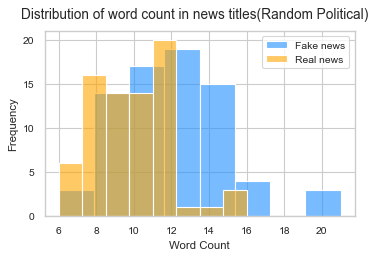

In [326]:
# WORD-COUNT
fake_title_word_count = fake_title['text'].apply(lambda x: len(str(x).split()))
real_title_word_count = real_title['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(5,3), dpi= 80)
plt.suptitle('Distribution of word count in news titles(Random Political)')
sns.histplot(fake_title_word_count,bins='auto', color="dodgerblue", label="Fake news",alpha=.6)
sns.histplot(real_title_word_count,bins='auto',color="orange", label="Real news",alpha=.6)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend();

/var/folders/3y/3k_hrx6d5d10jv_0k1vzfqt80000gn/T/ipykernel_9110/1390194016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_dec['word_count']= articles_dec['data'].apply(lambda x: len(str(x).split()))


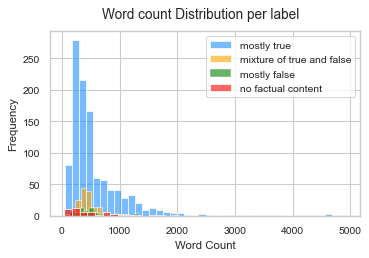

In [327]:
# WORD-COUNT
articles_orig['word_count']= articles_orig['data'].apply(lambda x: len(str(x).split()))

x1 = articles_orig.loc[articles_orig.label=='mostly true', 'word_count']
x2 = articles_orig.loc[articles_orig.label=='mixture of true and false', 'word_count']
x3 = articles_orig.loc[articles_orig.label=='mostly false', 'word_count']
x4 = articles_orig.loc[articles_orig.label=='no factual content', 'word_count']

plt.figure(figsize=(5,3), dpi= 80)
plt.suptitle('Word count Distribution per label')
sns.histplot(x1,bins=40, color="dodgerblue", label="mostly true",alpha=.6)
sns.histplot(x2, bins=40,color="orange", label="mixture of true and false",alpha=.6)
sns.histplot(x3,bins=15, color="green", label="mostly false", alpha=.6)
sns.histplot(x4,bins=15, color="red", label="no factual content", alpha=.6)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend();

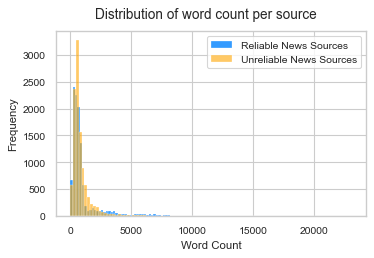

In [330]:
# WORD-COUNT
reliable_word_count = reliable_orig['content'].apply(lambda x: len(str(x).split()))
unreliable_word_count = unreliable_orig['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(5,3), dpi= 80)
plt.suptitle('Distribution of word count per source')
sns.histplot(reliable_word_count,bins=100, color="dodgerblue", label="Reliable News Sources",alpha=.9)
sns.histplot(unreliable_word_count,bins=100,color="orange", label="Unreliable News Sources",alpha=.6)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend();

We can see that articles belong to the fake news category are shorter than real news. This suggests that fake news articles tend to be shorter than real news articles, which may be a tactic used to make them more appealing or easier to read. It is important to note that the length of an article does not necessarily reflect its accuracy or credibility, and it is always important to carefully evaluate the content and sources of information.

### Distribution of labels in MisInfo Dataset
The plot below shows the distribution of labels in the dataset. We can observe in the plot below themajority of data belongs to the mostly true class and there is a quite significant imbalance in the classes. As a result we decided to merge the "mixed of true and false," "mostly false," and "no factual content" categories, resulting in a total of 290 observations. As a result, we sample 290 observations from the mostly true class. This decision was made to address the class imbalance and improve the accuracy of our analysis. It is important to carefully consider the distribution of classes when analyzing data, as imbalanced classes can affect the performance of the text classification and the interpretability of the results.

Text(0.5, 1.0, 'Distribution of Labels')

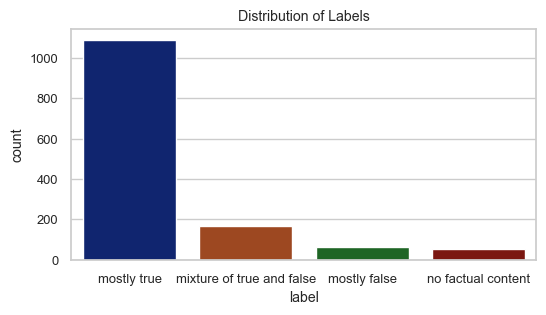

In [132]:
#Plot distribution of labels
plt.figure(figsize=(6, 3))
plt.tight_layout()
sns.countplot(data=articles_orig, x='label',palette=sns.color_palette('dark'))
plt.title('Distribution of Labels')

### Fake news sources
The plot illustrates the top sources with the most articles as provided in the Misinfotext dataset.We can see that the majority of fake news is written by rightwingnews, eaglerising, occupydemocrats, and addictinginfo. In contrast, politi.co, cnn.itm, and abcn.ws produce mostly real news. These findings suggest that certain sources may be more likely to produce fake or misleading news, and it is important for readers to be aware of the credibility of the sources they are reading.

Text(0.5, 1.0, 'Fake news source')

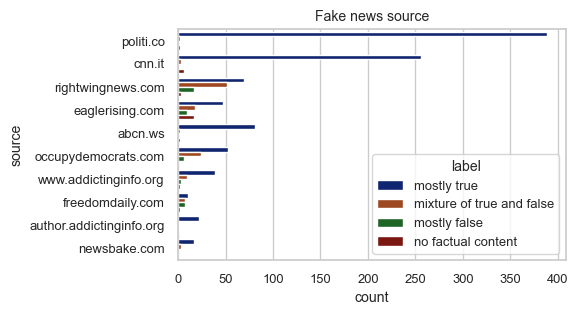

In [334]:
# Which newspaper is writing the majority of fake news
plt.figure(figsize=(5, 3))
plt.tight_layout()
# Set the font size to be larger
sns.set_context("notebook", font_scale=0.85)
sns.countplot(articles_orig, y='source', hue='label', palette='dark',
             order=articles_orig.source.value_counts().iloc[:10].index)
plt.title('Fake news source')

### Most common words
We first use the function we defined above to find the 20 most common words in each dataset. 

In [133]:
#Find most common words in Random_political dataset
stem_df_fake=common_words(proc_fake['stem'] )
stem_df_real=common_words(proc_real['stem'] )

The plots below show the most common words on the titles after stemming.

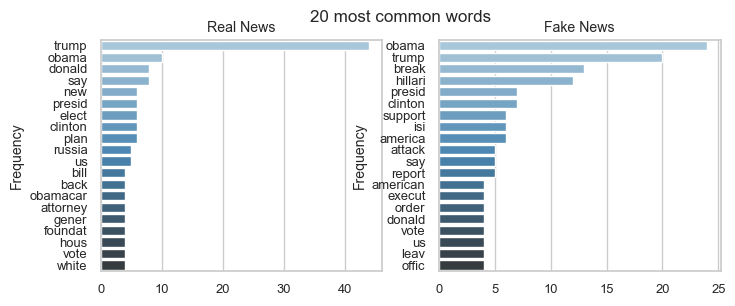

In [141]:
# plot 20 most common words after stemming
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('20 most common words')
sns.set_style("whitegrid")
sns.barplot(data=stem_df_fake, y='Word', x='Count', palette=sns.color_palette('Blues_d', 20), ax=axes[1],orient="h").set(
    title='Fake News', xlabel="", ylabel='Frequency')
sns.barplot(data=stem_df_real, y='Word', x='Count', palette=sns.color_palette('Blues_d', 20), ax=axes[0], orient="h").set(
    title='Real News', xlabel="", ylabel='Frequency')
plt.show()

In [142]:
common_df_real = common_words(proc_articles.loc[proc_articles['label'] == 'real', 'stem'])
common_df_fake = common_words(proc_articles.loc[proc_articles['label'] == 'fake', 'stem'])

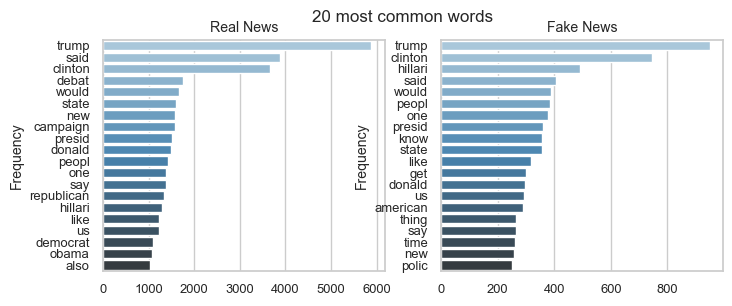

In [144]:
# plot 10 most common words without and with stemming
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.set_style("whitegrid")
fig.suptitle('20 most common words')
sns.barplot(data=common_df_real, y='Word', x='Count', palette=sns.color_palette('Blues_d', 20), ax=axes[0],
            orient="h").set(
    title='Real News', xlabel="", ylabel='Frequency')
sns.barplot(data=common_df_fake, y='Word', x='Count', palette=sns.color_palette('Blues_d', 20), ax=axes[1],
            orient="h").set(
    title='Fake News', xlabel="", ylabel='Frequency')
plt.show()

The `WordCloud` library can be used to produce a word cloud of the text that's easier to interpret than the plots above.A word cloud is a visual representation of the frequency of words in a piece of text.The size of each word is proportional to its frequency in the text. We will use the text in its original form for this purpose.

Text(0.5, 1.0, 'Fake news')

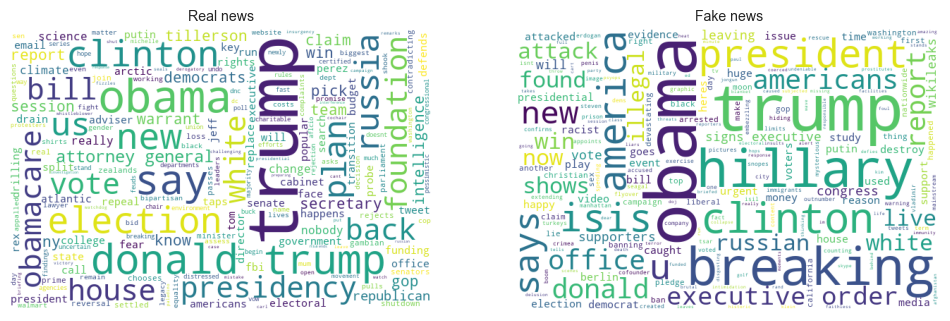

In [145]:
#Fake news
all_words_lem_fake = ' '.join([word for word in proc_fake['text']])
wordcloud_fake = WordCloud(width=600,
                      height=400,
                      random_state=2,
                      max_font_size=100,
                      background_color="white").generate(all_words_lem_fake)
#Real news
all_words_lem_real = ' '.join([word for word in proc_real['text']])
wordcloud_real= WordCloud(width=600,
                           height=400,
                           random_state=2,
                           max_font_size=100,
                           background_color="white").generate(all_words_lem_real)
# Create a figure object and set its size and title
fig = plt.figure(figsize=(12, 6))
# Adds a subplot at the 1st position
ax = fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(wordcloud_real)
plt.axis('off')
plt.title("Real news")
# Adds a subplot at the 2nd position
ax = fig.add_subplot(1, 2, 2)
# showing image
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title("Fake news")

We observe that real news titles words include the names of the candidates, terms related to the political parties and campaigns, and words related to specific issues or events that are relevant to the election. In fake news title we can still observe the names of the candidates in a different order, terms that are designed to be sensational or inflammatory like "breaking","attack", and words that are intended to evoke strong emotions in the reader as "america", "isis","russian" ect. 

Text(0.5, 1.0, 'rightwingnews.com')

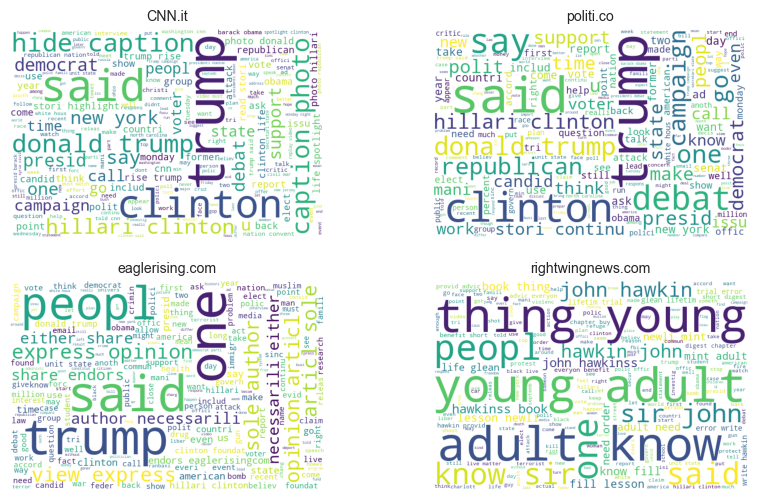

In [323]:
# %% WordCloud
# Fake news
all_words_lem_eagle = ' '.join(
    [word for word in proc_articles.loc[proc_articles['source'] == 'eaglerising.com', 'text_string']])
wordcloud_eagle = WordCloud(width=600,
                           height=400,
                           random_state=2,
                           max_font_size=100,
                           background_color="white").generate(all_words_lem_eagle)
# Real news
all_words_lem_cnn = ' '.join([word for word in proc_articles.loc[proc_articles['source'] == 'cnn.it', 'text_string']])
wordcloud_cnn = WordCloud(width=600,
                          height=400,
                          random_state=2,
                          max_font_size=100,
                         background_color="white").generate(all_words_lem_cnn)

# Real news
all_words_lem_right = ' '.join(
    [word for word in proc_articles.loc[proc_articles['source'] == 'rightwingnews.com', 'text_string']])
wordcloud_right = WordCloud(width=600,
                            height=400,
                            random_state=2,
                            max_font_size=100,
                           background_color="white").generate(all_words_lem_right)

# Real news
all_words_lem_pol = ' '.join(
    [word for word in proc_articles.loc[proc_articles['source'] == 'politi.co', 'text_string']])
wordcloud_pol = WordCloud(width=600,
                          height=400,
                          random_state=2,
                          max_font_size=100,
                          background_color="white").generate(all_words_lem_pol)

# Create a figure object and set its size and title
fig = plt.figure(figsize=(10, 6))
# Adds a subplot at the 1st position
ax=fig.add_subplot(2, 2, 1)
# showing image
plt.imshow(wordcloud_cnn)
plt.axis('off')
plt.title("CNN.it")

# Adds a subplot at the 2nd position
ax= fig.add_subplot(2, 2, 2)
# showing image
plt.imshow(wordcloud_pol)
plt.axis('off')
plt.title("politi.co")

# Adds a subplot at the 3rd position
ax = fig.add_subplot(2, 2, 3)
# showing image
plt.imshow(wordcloud_eagle)
plt.axis('off')
plt.title("eaglerising.com")

# Adds a subplot at the 4th position
ax=fig.add_subplot(2, 2, 4)
# showing image
plt.imshow(wordcloud_right)
plt.axis('off')
plt.title("rightwingnews.com")


The plot above shows the word clouds for real and fake news sources. For real news, we selected cnn.it and politi.co, and for fake news, we chose eaglerising.com and rightwingnews.com.It is important to note that these word clouds only represent a sample of the articles from these sources and may not be representative of the content of all articles published by these sources.

In the real news articles, we observe that the words used are consistent with the findings above, including the names of the candidates and terms related to the campaign. The only difference we can note is the inclusion of the words "hide" and "photo" in the politi.co word cloud.

In the fake news articles, we again see some similarity with the above dataset. Populist terms such as "us," "people," and "state" are present, as well as terms related to the political parties ("republican," "democrat," and "right"). Sensationalist terms such as "kill," "attack," and "bomb" are also present, potentially indicating an attempt to evoke strong emotions in the reader. 

Right wings news seems to refer a lot to "John hawking" who is the founder of this outlet and seems to write most of the articles. We observe that the words "young","adult","people", "know","said" are the most common

Text(0.5, 1.0, 'Unreliable news sources')

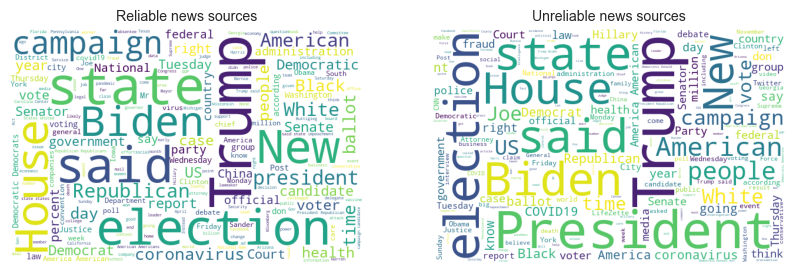

In [171]:
## Wordcloud
all_words_reliable = ' '.join([word for word in reliable['summary']])
wordcloud_reliable = WordCloud(width=600,
                               height=400,
                               random_state=2,
                               max_font_size=100,
                              background_color="white").generate(all_words_reliable)

all_words_unreliable = ' '.join([word for word in unreliable['summary']])
wordcloud_unreliable = WordCloud(width=600,
                           height=400,
                           random_state=2,
                           max_font_size=100,
                          background_color="white").generate(all_words_unreliable)

# Adds a subplot at the 1st position
# Create a figure object and set its size and title
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(wordcloud_reliable)
plt.axis('off')
plt.title("Reliable news sources")
# Adds a subplot at the 2nd position
ax = fig.add_subplot(1, 2, 2)
# showing image
plt.imshow(wordcloud_unreliable)
plt.axis('off')
plt.title("Unreliable news sources")

Finally,again a comparison of the wordclouds from fake and reliable news sources reveals that fake news articles tend to use more populist language, such as the word 'people'. Examining the fake news sources specifically, we see some differences between the language used in 2016 and 2020. While the pandemic is a notable theme in both time periods, the words 'attack' and 'war' are less common in the 2020 articles. On the other hand, words such as 'court', 'law', 'fraud', and 'police' are more prevalent in the 2020 fake news articles.

## Sentiment Analysis
We decided to perform sentiment analysis only on the news titles from the political_random dataset and articles from the MisInfoText Dataset. This is because the titles are short and the MisInfoText Dataset is small, making it feasible to perform sentiment analysis on the entire dataset. Additionally, since we extracted summaries from the NELA dataset, the overall sentiment of the original text may have been lost, and thus we won't be able to extract valuable information.

In general, the title of a news article often provides a summary or overview of the content of the article, and can convey the overall sentiment or emotion of the article. For example, a news article with a positive or optimistic title might indicate that the article is more likely to present a positive or favorable view of a particular subject, while a news article with a negative or pessimistic title might indicate that the article is more likely to present a negative or unfavorable view.

We will use the original titles tokenization may not be necessary or may even be harmful, as it could break up important phrases or clauses that are necessary for understanding the meaning of the text.Same applies to stopwords as by removing the can lose contextual information.

We'll start by merging the two dataframes containing the titles and add labels. Real news are represented by 0 and fake news by 1.

In [287]:
# Merge dataframes and add labels
# Real news label
real_title['label']=0
# Fake news label
fake_title['label']=1
titles=pd.concat([fake_title,real_title])

To perfom sentiment analysis we use TextBlob from the `spaCy` library.
The polarity attribute of a TextBlob object represents the polarity of the text which refers to the sentiment of the text and can be positive, negative, or neutral. The polarity of a text is typically represented as a value between -1.0 and 1.0. The subjectivity attribute of a TextBlob object represents the subjectivity which refers to the personal or emotional perspective of the text, as opposed to objectivity, which refers to a neutral or factual perspective. The subjectivity of a text can range from 0.0, which is completely objective, to 1.0, which is completely subjective.

We start by defining the two functions.It's important to note this could have been done by merging the two functions and adding the results to the dataframe. 

In [288]:
#Sentiment Analysis
nlp_sent = spacy.load('en_core_web_sm')
nlp_sent.add_pipe('spacytextblob')

def get_polarity(text):
    doc = nlp_sent(text)
    sentiment= doc._.blob.polarity
    #Convert result to positive,neutral or negative
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

def get_subjectivity(text):
    doc = nlp_sent(text)
    # Get subjectivity
    subj=doc._.blob.subjectivity
    #Convert result to positive,neutral or negative
    if subj > 0.5:
        return 'subjective'
    else:
        return 'objective'

Next we apply the functions to our datasets and create a new column that will contain the results.

In [293]:
# get the start time
st = time.time()
#Find sentiment and subjectivity 
titles['polarity'] = titles['text'].apply(get_polarity)
titles['subjectivity'] = titles['text'].apply(get_subjectivity)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# get the start time
st = time.time()
#Find sentiment and subjectivity 
proc_articles['polarity'] = proc_articles['text'].apply(get_polarity)
proc_articles['subjectivity'] = proc_articles['text'].apply(get_subjectivity)
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 2.393824815750122 seconds
Execution time: 241.22474002838135 seconds


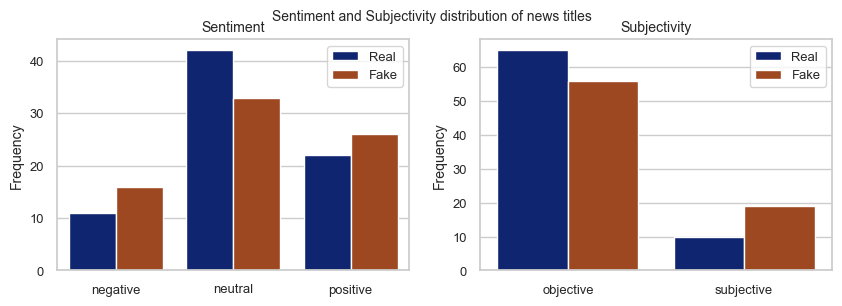

In [294]:
# Visualise sentiment and subjectivity on 
# news titles
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Sentiment and Subjectivity distribution of news titles',fontsize=10)
sns.set_style("whitegrid")
sns.countplot(data=titles, x='polarity',hue='label',palette=sns.color_palette('dark'), ax=axes[0]).set(
    title='Sentiment', xlabel="", ylabel='Frequency')
axes[0].legend(['Real', 'Fake'])
sns.countplot(data=titles, x='subjectivity',hue='label',palette=sns.color_palette('dark'), ax=axes[1]).set(
    title='Subjectivity', xlabel="", ylabel='Frequency')
axes[1].legend(['Real', 'Fake'])
plt.show()

The plot above shows the sentiment and objectivity of the news titles for both real and fake news titles. We can see that real news titles are primarily neutral and objective, while fake news titles are less. This is to be expected, as fake news is often designed to elicit strong emotions in the reader. We can also see that there are more subjective fake news article titles than real news. Overall, these results suggest that fake news titles are more likely to be biased and emotionally charged than real news titles.

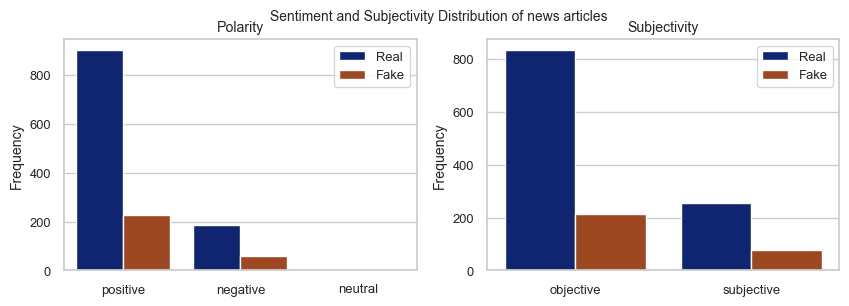

In [295]:
# Visualise sentiment and subjectivity on 
# news articles
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Sentiment and Subjectivity Distribution of news articles',fontsize=10)
sns.set_style("whitegrid")
sns.countplot(data=proc_articles, x='polarity',hue='label',palette=sns.color_palette('dark'), ax=axes[0]).set(
    title='Polarity', xlabel="", ylabel='Frequency')
axes[0].legend(['Real', 'Fake'])
sns.countplot(data=proc_articles, x='subjectivity',hue='label',palette=sns.color_palette('dark'), ax=axes[1]).set(
    title='Subjectivity', xlabel="", ylabel='Frequency')
axes[1].legend(['Real', 'Fake'])
plt.show()

The plot above illustrates that the vast majority of articles elicit either positive or negative sentiment, with very few being neutral. Notably, the majority of articles from fake news sources show positive sentiment. Of these, roughly 200 are labelled as objective, while approximately 90 are labelled as subjective.

## Text Classification
### Preprocess Dataframes

Next, we will perform text classification using the spaCy library. For the text classification task, we will only require a text column and a label column.

To prepare the datasets for text classification, we use the preprocessed datasets from above and create our final training dataset. 

For the title dataset, we will not preprocess the text further as they are already short and removing unwanted text may decrease the accuracy of the model.

We mentioned above that the MisInfoText dataset is significantly unbalanced and as a result we will sample 290 observations from each class. This decision was made to address the class imbalance and improve the accuracy of our analysis. It is important to carefully consider the distribution of classes when analyzing data, as imbalanced classes can affect the performance of the text classification and the interpretability of the results.
We will use the text column from the processed dataframes which contains the lowercase text after having removing symbols and urls.

In [335]:
# MisInfoText dataset
# Sample observations from each class 
articles = proc_articles.groupby('label').sample(n=290)
articles.groupby(['label'])['label'].count()

label
fake    290
real    290
Name: label, dtype: int64

In [336]:
articles = articles[['text','label']].reset_index(drop=True)
articles.head()

,text,label
0,obama tells america to protect his legacy tha...,fake
1,according to charlotte police about 70 of prot...,fake
2,who do you thinkyou fooling blacklivesmatter p...,fake
3,video man yells 3 brutal words inhillary face ...,fake
4,democratic national committee interim chairwom...,fake


In [337]:
# Convert labels to 0 for fake news and 1 for real news
articles.loc[articles["label"] == 'real', 'label'] = 0
articles.loc[articles["label"] == 'fake', 'label'] = 1
articles.head()

,text,label
0,obama tells america to protect his legacy tha...,1
1,according to charlotte police about 70 of prot...,1
2,who do you thinkyou fooling blacklivesmatter p...,1
3,video man yells 3 brutal words inhillary face ...,1
4,democratic national committee interim chairwom...,1


Next, we add a label column to the nela-gt-2020 dataset and merge the two dataframes ,keeping only the summary column and label columns. As we mentioned above we will try to train a model by only using the most important words in the text and thus using the summary.

In [338]:
# Add a column of zeros to the dataframe
reliable = reliable.assign(label=0)
unreliable = unreliable.assign(label=1)

dataset=pd.concat([reliable[['summary','label']],unreliable[['summary','label']]],ignore_index=True)
# Rename column summary to text
dataset = dataset.rename(columns={'summary': 'text'})
dataset.head()

,text,label
0,election The voters Republicans Democrats GOP ...,0
1,Biden Bauer Sanders But Democratic The All He ...,0
2,election like people And It ensuring going vot...,0
3,mail states allow ballots But voters voting El...,0
4,Sanders people Cohen New said But Deal Democra...,0


Before training our model we need to define our preprocess function that will convert into spaCy’s binary training and testing data format by creating Doc objects. It's unnecessary to remove unwanted text such as symbols as we already did it above. In this instance, deleting stopwords and punctuation is unnecessary as spaCy's transformer model automatically connects with a tokenizer. Furthermore, lemmatization is unnecessary since prefixes and suffixes may provide essential information. 

In [339]:
# Preprocess dataframe
def preprocess(df):

    # Store the data into tuples
    data = tuple(zip(df.text.tolist(), df.label.tolist()))

    # Load English library from SpaCy
    nlp = spacy.load("en_core_web_sm")

    # Create list for docs
    docs = []

    # Encode Classes
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total=len(data)):

        if label == 0:
            doc.cats['real'] = 1
            doc.cats['fake'] = 0
        else:
            doc.cats['real'] = 0
            doc.cats['fake'] = 1
        # print(doc.cats)
        docs.append(doc)

    return df, docs

To create our training and testing datasets, we will use the train_test_split function from the scipy library. For the title dataset, we will set aside 10% of the data for testing, as the dataset is small.

In [340]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(titles.text, titles.label, test_size=0.10,shuffle=True)

#Create dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Print values
print("Train:", len(train_df), "Test:", len(test_df))

Train: 135 Test: 15


Next we save the datasets in the [data folder]() in a training and testing folder.

In [341]:
st = time.time()

# Train test split
# Preprocess train data
print("Processing train data")
train_data, train_docs = preprocess(train_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./data/data_fakereal/train.spacy")

# Preprocess test data
print("Processing test data")
test_data, test_docs = preprocess(test_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./data/data_fakereal/dev.spacy")

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Processing train data


100%|████████████████████████████████████████| 135/135 [00:00<00:00, 350.13it/s]


Processing test data


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 397.62it/s]


Execution time: 3.6174049377441406 seconds


We repeat the process for the two remaining dataframes.

In [342]:
st = time.time()# Train test split
X_train, X_test, y_train, y_test = train_test_split(articles.text, articles.label, test_size=0.20)

# Create dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Print values
print("Train:", len(train_df), "Test:", len(test_df))

# Preprocess train data
print("Processing train data for MisinfoText")
train_data, train_docs = preprocess(train_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./data/data_buzzfeed/train.spacy dataset")

# Preprocess test data
print("Processing test data MisinfoTExt dataset")
test_data, test_docs = preprocess(test_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./data/data_buzzfeed/dev.spacy")

# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Train: 464 Test: 116
Processing train data for MisinfoText


100%|█████████████████████████████████████████| 464/464 [00:25<00:00, 17.89it/s]


Processing test data MisinfoTExt dataset


100%|█████████████████████████████████████████| 116/116 [00:07<00:00, 14.66it/s]


Execution time: 36.452123165130615 seconds


In [343]:
st = time.time()# Train test split
# Train test split
X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset.label, test_size=0.20,shuffle=True)

# Create dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Print values
print("Train:", len(train_df), "Test:", len(test_df))

# Preprocess train data
print("Processing train data for nela-gt-2020")
train_data, train_docs = preprocess(train_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./data/data_nela/train.spacy")

# Preprocess test data
print("Processing test data for nela-gt-2020")
test_data, test_docs = preprocess(test_df)
# Save doc in a binary file to disc
doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./data/data_nela/dev.spacy")

# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Train: 11422 Test: 2856
Processing train data for nela-gt-2020


100%|████████████████████████████████████| 11422/11422 [01:49<00:00, 104.41it/s]


Processing test data for nela-gt-2020


100%|██████████████████████████████████████| 2856/2856 [00:27<00:00, 103.96it/s]


Execution time: 146.13721585273743 seconds


### Model Training and Evaluation
#### Specify the configuration file

For the text classification model we use spaCys Training Pipelines and Models. spaCy creates a Training config file based on a provided base configuration file that's generated by the user and includes all settings and hyperparameters for training our pipeline.
  
We use Spacy’s quickstart widget from [spacy documentation](https://spacy.io/usage/training#quickstart) to generate a starter config with the recommended settings for our specific use case. We specify the different pipelines.For the Random_political and nela-gt-2020 dataset the pipeline is composed by `textcat` component and chose to optimise for efficiency . All other parameters are set to defaults. For the MisInfo dataset we will use a pipeline composed by `tok2vek` ,`textcat` and `tagger` components.
 
The tok2vec pipeline is used to extract contextualized word vectors from a text.Generally, if the dataset contains a large number of unique words and punctuation and the relationships between these words and punctuation are important for the text classification task, then using the tok2vec component may be helpful. However, if the dataset contains a small number of unique words and the relationships between these words are not important for the text classification task, then using the tok2vec component may not be necessary. As a result, we won't use this component when using the titles and the 100 summary words for text classification. In the context of text classification, the 100 summary words could be used directly as features for the model, without the need to first convert them into a numerical representation. 

The textcat pipeline is built on top of the TextCategorizer component, which is a neural network-based model that is trained to predict the category of a text based on its content. The textcat pipeline needs a pre-defined set of categories.

The parser component is used to analyze the grammatical structure and dependencies of a sentence in more detail, while the tagger component is used to assign part-of-speech tags to each word in the sentence. Whether to use the parser or tagger component, or both, for a specific task will depend on the characteristics of the dataset and the specific goals of the task.
It's also important to consider the trade-off between model complexity and performance. Using more components can add additional information and improve model performance, but it can also increase the complexity of the model and require more training data. 

It is worth to note that before choosing those final models, we tested various options and ultimately decided to use the below pipelines.The text classification model for the title dataset was trained using a parser and a tagger separately, but the results were not satisfactory. This may be due to the small size of the dataset and the short length of the sentences, which may have limited the amount of information available to the model. Similarly, the MisInfoText model was also trained using a parser, but the results were not satisfactory. This may be because the fake news class in this dataset contains articles that are of poor quality, as it was created by combining various categories. The nela-gt-2020 dataset was the only model that was directly trained using the textcat component.

The text classification models are already trained using the next two cells and can be loaded from the output folder for each dataset.You don't need to run the next two cells if you don't want to retrain the models. The best model can be found in the model_best, and it contains the configuration file that was used to train the model with the highest accuracy.

The dataset contains 135 samples and as a result we set the batch size to a smaller value such as 32. This would allow the model to process a smaller number of examples at once, which may be more appropriate for a smaller dataset.

In [356]:
#Initialise confing
# get the start time
st = time.time()
os.system(' python3 -m spacy init fill-config ./base_config_rf.cfg ../code/config.cfg')
# get the start time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

✔ Auto-filled config with all values
✔ Saved config
../code/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
Execution time: 3.0747499465942383 seconds


#### Training the model
The output is saved in the output_fakereal folder.

In [357]:
# get the start time
st = time.time()
#Train pipeline:
os.system('python3 -m spacy train ./config.cfg --output ./outputs/output_fakereal')
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[2023-01-04 15:28:59,888] [INFO] Set up nlp object from config
[2023-01-04 15:28:59,904] [INFO] Pipeline: ['textcat']
[2023-01-04 15:28:59,907] [INFO] Created vocabulary
[2023-01-04 15:28:59,909] [INFO] Finished initializing nlp object
[2023-01-04 15:29:00,001] [INFO] Initialized pipeline components: ['textcat']


ℹ Saving to output directory: outputs/output_fakereal
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.25       72.22    0.72
 12     200         19.59       86.11    0.86
 27     400          2.15       86.11    0.86
 45     600          0.65       86.11    0.86
 67     800          0.31       86.11    0.86
 94    1000          0.17       86.11    0.86
127    1200          0.10       86.11    0.86
166    1400          0.07       86.11    0.86
216    1600          0.04       86.11    0.86
275    1800          0.03       86.11    0.86
✔ Saved pipeline to output directory
outputs/output_fakereal/model-last
Execution time: 9.43397831916809 seconds


This log output shows the values for these metrics at different points during the training process, allowing you to monitor the performance of the model and assess its progress.

* "E" and "#": The epoch number and batch number, respectively. An epoch is a single pass through the entire training dataset, while a batch is a subset of the training dataset. We can observe that in this instance the model run 313 epocs. 
* "LOSS TEXTCAT": The loss of the textcat component of the model, which is responsible for performing text classification.
* "CATS_SCORE": The classification score, which is a measure of the model's performance on the text classification task. This score is calculated as the average F1-score across all categories.
* "SCORE": The overall score, which is a combination of the classification score and the part-of-speech tagging accuracy.

In general, a model that is performing well will typically have low values for the loss metrics (e.g., LOSS TOK2VEC, LOSS TEXTCAT, LOSS TAGGER), high values for the accuracy or score metrics (e.g., CATS_SCORE, TAG_ACC, SCORE), and good generalization performance (i.e., the model performs well on unseen data).

In this case the loss metrics are small while the score is equal to 0.86. In the section below we will test the model on unseen data.

Next, we specify a different configuration file for the MisInfoText dataset. In this case, we use the pipeline with the components we specified above(`tok2vek` ,`textcat` and `tagger`) and a batch size equal to 128  This would allow the model to process a larger number of examples at once, which may be more efficient for this dataset.

In [360]:
# get the start time
st = time.time()
#
os.system(' python3 -m spacy init fill-config ./base_config_buzz.cfg ../code/config.cfg')
# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

✔ Auto-filled config with all values
✔ Saved config
../code/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
Execution time: 3.523625135421753 seconds


The output is saved in the outputs folder as output_misinfo.

In [361]:
# get the start time
st = time.time()

#Train pipeline
os.system('python3 -m spacy train config.cfg --output ./outputs/output_misinfo')

# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[2023-01-04 15:47:35,022] [INFO] Set up nlp object from config
[2023-01-04 15:47:35,042] [INFO] Pipeline: ['tok2vec', 'textcat', 'tagger']
[2023-01-04 15:47:35,047] [INFO] Created vocabulary
[2023-01-04 15:47:36,879] [INFO] Added vectors: en_core_web_lg
[2023-01-04 15:47:38,780] [INFO] Finished initializing nlp object
[2023-01-04 15:47:52,523] [INFO] Initialized pipeline components: ['tok2vec', 'textcat', 'tagger']


ℹ Saving to output directory: outputs/output_misinfo
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'textcat', 'tagger']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  LOSS TAGGER  CATS_SCORE  TAG_ACC  SCORE 
---  ------  ------------  ------------  -----------  ----------  -------  ------
  0       0          0.00          0.25       192.31       34.39    29.18    0.32
  0     200        614.92         79.90     26621.84       47.89    92.45    0.70
  0     400        514.70         72.74     11116.01       34.81    93.76    0.64
  1     600        588.02         65.66     10313.10       45.03    94.01    0.70
  1     800        667.28         61.13      9337.31       54.99    94.59    0.75
  2    1000        628.50         61.99      7527.33       41.06    94.70    0.68
  2    1200        719.29

The output log is similar to above with the exception of those columns:

* "LOSS TAGGER": The loss of the tagger component of the model, which is responsible for labeling the part-of-speech tags for the input text.
* "LOSS TOK2VEC": The loss of the tok2vec component of the model, which is responsible for generating word vectors (i.e., embeddings) from the tokenized text is equal to 0.01.

According to the output log, the number of epochs for the model was 4, the loss was 0.02, and the overall score was 0.86. These results indicate that the performance of the model is quite good. It should be noted, however, that the classification accuracy may be lower than previous models due to the larger size of the training data and potentially less accurate labeling of the articles. Despite these factors, the model still demonstrates strong performance.

For the nela dataset, the configuration file we specify only the `text_cat` component as we apply the model to the summary text. For a dataset containing 12000 samples, the batch size could potentially be set to a larger value such as 128, 256, or 512.We choose a value of 256. This would allow the model to process a larger number of examples at once, which may be more efficient for a larger dataset.t.

In [353]:
# get the start time
st = time.time()

os.system(' python3 -m spacy init fill-config ./base_config_nela.cfg ../code/config.cfg')

# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

✔ Auto-filled config with all values
✔ Saved config
../code/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
Execution time: 2.1211559772491455 seconds


The output is saved in the outputs folder in output_nela.

In [355]:
# get the start time
st = time.time()

os.system('python3 -m spacy train config.cfg --output ./outputs/output_nela')

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[2023-01-04 15:20:27,300] [INFO] Set up nlp object from config
[2023-01-04 15:20:27,319] [INFO] Pipeline: ['textcat']
[2023-01-04 15:20:27,322] [INFO] Created vocabulary
[2023-01-04 15:20:27,323] [INFO] Finished initializing nlp object
[2023-01-04 15:20:43,345] [INFO] Initialized pipeline components: ['textcat']


ℹ Saving to output directory: outputs/output_nela
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.25       33.07    0.33
  0     200         39.57       79.10    0.79
  0     400         25.86       82.57    0.83
  0     600         22.40       85.39    0.85
  0     800         17.12       88.51    0.89
  0    1000         14.58       90.26    0.90
  0    1200         12.50       92.23    0.92
  0    1400         10.42       92.16    0.92
  0    1600          9.75       93.00    0.93
  0    1800          8.73       93.66    0.94
  0    2000          8.52       93.76    0.94
  0    2200          7.72       94.50    0.95
  0    2400          7.43       94.89    0.95
  0    2600    

The output log shows that the number of epochs is equal to 4, the loss is equal to 0.02 and the overall classification score is equal to 0.96.The results show that the performance of the models is very good.

## Evaluation
To evaluate the generalization performance of the models, we will test them on the nela-gt-2020 dataset. For the title classification model, we will use the title column as input, and for the article and summary classification models, we will use the text column. It is important to note that because this dataset contains a variety of labels for the news sources and not individual articles, and because we will be randomly sampling from the dataset, we may not have an entirely accurate test sample. This could impact the results of the evaluation.

We sample 200 observations from the reliable and unreliable sources from the nela dataset containing article titles and text and test the models. We compute the confusion matrix for each dataset.A confusion matrix is a table that is used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the model for each class. The rows of the matrix represent the actual classes and the columns represent the predicted classes

In [ ]:
# Load model
nlp_model_fr = spacy.load('./outputs/output_fakereal/model-best')
# Make predictions on the test data
predicted_labels = []
true_labels = []

#Sample titles for nela-gt-2020
random_rows_fake = unreliable.sample(200)
random_rows_real = reliable.sample(200)

test_data=pd.concat([random_rows_fake[['title','text','label']],random_rows_real[['title','text','label']]])
labels = test_data['label'].tolist()
true_labels = ["fake" if value == 1 else "real" for value in labels]

for index, row in test_data.iterrows():
    doc = nlp_model_fr(row['title'])
    predicted_label = max(doc.cats, key=doc.cats.get)
    predicted_labels.append(predicted_label)

# Calculate the confusion matrix
confusion_matrix_fr = confusion_matrix(true_labels, predicted_labels)

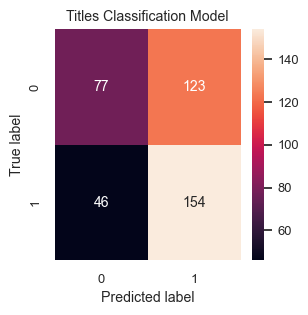

In [396]:
# Visualise confusion matrix
fig = plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix_fr, annot=True, fmt='d')
plt.title('Titles Classification Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The confusion matrix indicates that the model is more accurate at predicting fake news titles than real news titles. This may be due to the fact that the NELA-GT dataset, which was collected in 2020, features different topics and language usage compared to more recent news articles. 

Upon closer examination of individual samples, we can evaluate why certain samples are misclassified. 

In [391]:
# Verify models 
# Load model
nlp_model_fr = spacy.load('./outputs/output_fakereal/model-best')
#Sample titles from nela-gt-2020 dataset
examples = reliable.sample(3)
for title in examples['title']:
    title= re.sub(r'[^\w\s]', "", title, flags=re.MULTILINE)
    doc_test_1 = nlp_model_fr(title)
    print(title)
    print("Predicted Cats:")
    print(doc_test_1.cats)

Japan has its own TrumpvsCuomo divide And its just as tense
Predicted Cats:
{'real': 0.5445737242698669, 'fake': 0.45542633533477783}
The Forgotten Governors Race
Predicted Cats:
{'real': 0.3048268258571625, 'fake': 0.6951731443405151}
The Daily 202 Two conservatives join liberals in Supreme Court ruling to protect LGBTQ workers
Predicted Cats:
{'real': 0.37997692823410034, 'fake': 0.6200230717658997}


Next we find the confusion for the MisInfo dataset using the text column of the sample.

In [ ]:
# Load model
nlp_model_misinfo = spacy.load('./outputs/output_misinfo/model-best')
# Make predictions on the test data
predicted_labels = []

for index, row in test_data.iterrows():
    doc = nlp_model_misinfo(row['text'])
    predicted_label = max(doc.cats, key=doc.cats.get)
    predicted_labels.append(predicted_label)

# Calculate the confusion matrix
confusion_matrix_misinfo = confusion_matrix(true_labels, predicted_labels)

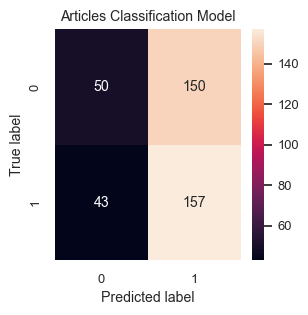

In [400]:
#Visualise confusion Matrix
fig = plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix_misinfo, annot=True, fmt='d')
plt.title('Articles Classification Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

The confusion matrix shows that again that the model is more accurate at predicting fake news than real news. This may be due to the same reasons as above. Moreover, it may be due that fake articles use more unique words, and it's easier to classify them.

Finally, we produce the confusion matrix for the nela-gt-2020 dataset using the text column.

In [398]:
# Load model
nlp_model_nela = spacy.load('./outputs/output_nela/model-best')
# Make predictions on the test data
predicted_labels = []

for index, row in test_data.iterrows():
    doc = nlp_model_nela(row['text'])
    predicted_label = max(doc.cats, key=doc.cats.get)
    predicted_labels.append(predicted_label)

# Calculate the confusion matrix
confusion_matrix_nela = confusion_matrix(true_labels, predicted_labels)

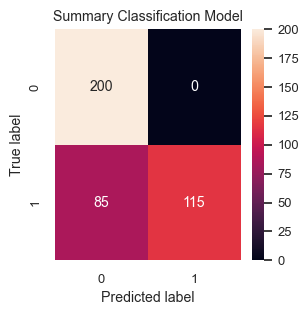

In [401]:
#Visualise confusion Matrix
fig = plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix_nela, annot=True, fmt='d')
plt.title('Summary Classification Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()   

The results reveal that the model outperforms the other two models in terms of classification accuracy. It is noteworthy that the model was tested on the entire body of text, rather than just the summary, and still achieved good performance. While the model performs well for the real news class, it is not as accurate for the fake news class. This could potentially be due to the way the data was labeled. Further investigation is needed to determine the exact cause of this discrepancy.

## Cluster
K-means clustering can be used to cluster a set of news articles into groups based on their similarity. To use k-means clustering for news articles, we need to first represent the articles as numerical vectors using TF-IDF and then apply the k-means algorithm to these vectors to cluster the articles into groups.

First we're going to merge the above dataframes and keep only the text column. Then we tokenize the articles before applying k-means clustering, as this can help to improve the accuracy of the clustering results.It allows the algorithm to compare the individual words or phrases in the articles, rather than the entire articles as a whole. This can help to identify more subtle similarities between the articles, and can result in more meaningful clusters.

In [403]:
# get the start time
st = time.time()
dataset_clust=pd.concat([reliable[['text','label']],unreliable[['text','label']]],ignore_index=True)
dataset_clust['tokens'] = dataset_clust['text'].apply(tokenize_row)
dataset_clust['tokens'] = dataset_clust['tokens'].apply(lambda x: ' '.join([item for item in x]))
dataset_clust.head()
# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 103.92187309265137 seconds


In [404]:
# get the start time
st = time.time()
# Define a tokenization function that uses the stemmer
from nltk.corpus import stopwords

stemmer = nltk.stem.PorterStemmer()
def stem_tokenize(text):
    # Remove stop words
    filtered_tokens = [word for word in text.split() if word not in stopwords.words('english')]
    # Stem the filtered tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return stemmed_tokens

# Vectorize the articles using TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents=None,
                             preprocessor=preProcess,
                             tokenizer=stem_tokenize,
                             lowercase=False,
                             sublinear_tf=True)
vectors = vectorizer.fit_transform(dataset_clust['tokens'])

# Apply k-means clustering to the vectors
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(vectors)

# Add the cluster labels to the dataframe
dataset_clust['cluster'] = kmeans.labels_

df = pd.DataFrame(vectors.todense()).groupby(dataset_clust['cluster']).mean()
terms = vectorizer.get_feature_names_out()
result = pd.DataFrame()
for i, r in df.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([terms[t] for t in np.argsort(r).tail(5)]))
    words = pd.DataFrame(data=[terms[t] for t in np.argsort(r).tail()]).transpose()
    result = result.append(words, ignore_index=True)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Cluster 0
senat,trial,trump,investig,impeach

Cluster 1
voter,state,elect,vote,ballot

Cluster 2
the,test,said,viru,coronaviru

Cluster 3
buttigieg,candid,warren,iowa,sander

Cluster 4
said,presid,i,the,trump
Execution time: 2223.2151460647583 seconds


From the results above,we can see that each cluster can be mapped to a category nicely. We can have distinct articles that refer about the impeachment of former president Donald Trump, the election process,the coronavirus pandemic, the democratic candidates and the republican candidate . Next we're going to visualise how many articles belong to each cluster.

Text(0.5, 1.0, 'Cluster Distribution')

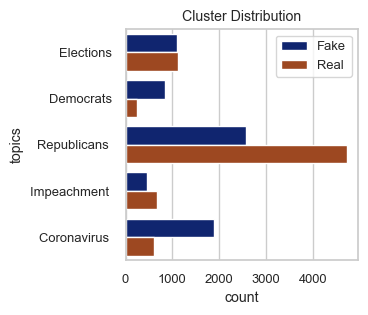

In [419]:
# Create mapping to merge classes
mapping = {0: 'Impeachment ', 1: 'Elections', 2: 'Coronavirus ',3: 'Democrats', 4: 'Republicans '}
# use the map function to change the values in the 'col1' column
dataset_clust.loc[:,'topics'] = dataset_clust['cluster'].map(mapping)

plt.figure(figsize=(3, 3))
plt.tight_layout()
# Set the font size to be larger
#sns.set_context("notebook", font_scale=0.85)
sns.countplot(dataset_clust, y='topics', hue='label', palette='dark')
plt.legend(['Fake', 'Real'])
plt.title('Cluster Distribution')

In the next step, we will visualize the distribution of articles across different clusters. From the visualization, it appears that the majority of the articles are related to the Republican Party and Donald Trump. This is also the topic that a significant proportion of the fake news articles cover. The second most common topic is the coronavirus. In the 'elections' cluster, the number of real and fake news articles is roughly equal. The only cluster where fake news articles outnumber real news articles is the 'impeachment' cluster."